In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [52]:
titanic_data = pd.read_csv("/Users/nishkashah/Downloads/titanic/train.csv")

In [53]:
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


<Axes: >

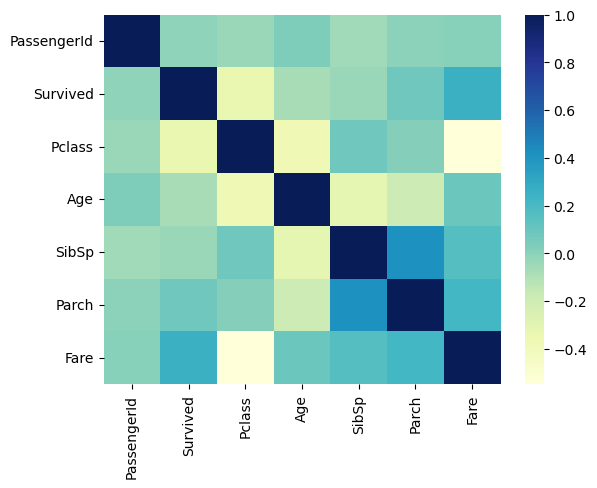

In [54]:
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")

In [55]:
# Instead of a typical train/test split, doing this to ensure features of importance (PClass, Fare) have similar distribution 
# in training and testing sets. Ex. all the people with high fare end up in train and low in test.

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
# Gives the rows from titanic_data that match respective train/test indices
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

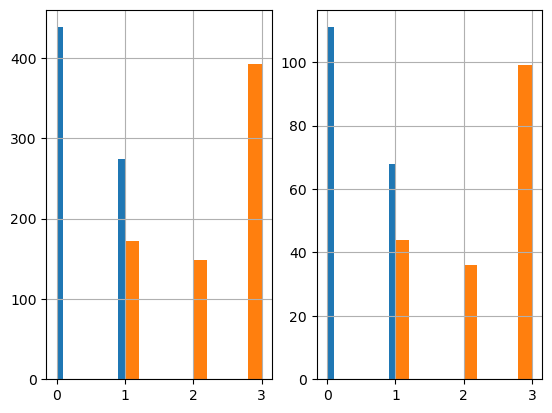

In [56]:
plt.subplot(1,2,1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()


In [57]:
strat_train_set.info()


<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 829 to 566
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [58]:
# To automatically fill missing data values rather than dropping those rows entirely. TransformerMixin gives fit_transform() method 

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__ (self):
        # Create the imputer once, for any missing values it replaces it with the mean
        self.imputer = SimpleImputer(strategy="mean")
    
    # Learn the mean from the training data only (training)
    def fit(self, X, y=None):
        self.imputer.fit(X[["Age"]])
        return self
    
    # Apply the learned mean to whatever data comes in (Train or Test)
    def transform(self, X):
        X['Age'] = self.imputer.transform(X[['Age']])
        return X

In [59]:
# Turning non-numerical features into binary by creating columns
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        column_names = ["Female", "Male"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X


In [60]:
class FeatureDropper(BaseEstimator, TransformerMixin):
     def fit(self, X, y=None):
        return self
     def transform(self, X):
         return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [61]:
pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [62]:
strat_train_set_transformed = pipeline.fit_transform(strat_train_set)

In [63]:
strat_train_set_transformed

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
829,830,1,1,62.000000,0,0,80.0000,0.0,0.0,0.0,1.0,0.0
213,214,0,2,30.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
162,163,0,3,26.000000,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
808,809,0,2,39.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
722,723,0,2,34.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
203,204,0,3,45.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0
538,539,0,3,29.653678,0,0,14.5000,0.0,0.0,1.0,0.0,1.0
109,110,1,3,29.653678,1,0,24.1500,0.0,1.0,0.0,1.0,0.0
29,30,0,3,29.653678,0,0,7.8958,0.0,0.0,1.0,0.0,1.0


In [64]:
X = strat_train_set_transformed.drop(["Survived"], axis=1)
y = strat_train_set_transformed['Survived']

# Scaling ensures Age 5 is not less valuable than Fare of 500. Uses z score to standardize. Note that scaling not needed for Decision Trees.
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
Y_data = y.to_numpy()

In [65]:
clf = RandomForestClassifier()

# Hyperparameters to test out. N_estimators is # of trees to vote, max_depth is how deep tree can get, min_samples_split is when do we stop asking questions.
# Total options is 4x3x3 = 36 different models
param_grid = [
    {
        "n_estimators": [10, 100, 200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 3, 4]
    }
]

# GridSearchCV will train 36 different models, and say which combination was winner. cv of 3 means train on chunk 1 and 2, test 3 (keep doing for each of the 3); 36x3=108 total training runs
# return_train_score also tells how well model did on training data instead of default of just giving test data
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, Y_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [66]:
final_clf =grid_search.best_estimator_

In [67]:
final_clf

RandomForestClassifier(max_depth=5)

In [68]:
strat_test_set_transformed = pipeline.fit_transform(strat_test_set)

In [69]:
strat_test_set_transformed

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
508,509,0,3,28.000000,0,0,22.5250,0.0,0.0,1.0,0.0,1.0
737,738,1,1,35.000000,0,0,512.3292,1.0,0.0,0.0,0.0,1.0
477,478,0,3,29.000000,1,0,7.0458,0.0,0.0,1.0,0.0,1.0
671,672,0,1,31.000000,1,0,52.0000,0.0,0.0,1.0,0.0,1.0
142,143,1,3,24.000000,1,0,15.8500,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
677,678,1,3,18.000000,0,0,9.8417,0.0,0.0,1.0,1.0,0.0
410,411,0,3,29.880559,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
866,867,1,2,27.000000,1,0,13.8583,1.0,0.0,0.0,1.0,0.0
765,766,1,1,51.000000,1,0,77.9583,0.0,0.0,1.0,1.0,0.0


In [71]:
X_test = strat_test_set_transformed.drop(["Survived"], axis=1)
Y_test = strat_test_set_transformed["Survived"]

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
Y_data_test = Y_test.to_numpy()

In [72]:
final_clf.score(X_data_test, Y_data_test)

0.8324022346368715

In [73]:
# Training model on all combined data
final_data = pipeline.fit_transform(titanic_data)

In [74]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [75]:
X_final = final_data.drop(["Survived"], axis=1)
Y_final = final_data["Survived"]

scaler = StandardScaler()
X_final_data = scaler.fit_transform(X_final)
Y_final_data = Y_final.to_numpy()


In [76]:
prod_clf = RandomForestClassifier()

# Hyperparameters to test out. N_estimators is # of trees to vote, max_depth is how deep tree can get, min_samples_split is when do we stop asking questions.
# Total options is 4x3x3 = 36 different models
param_grid = [
    {
        "n_estimators": [10, 100, 200, 500],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 3, 4]
    }
]

# GridSearchCV will train 36 different models, and say which combination was winner. cv of 3 means train on chunk 1 and 2, test 3 (keep doing for each of the 3); 36x3=108 total training runs
# return_train_score also tells how well model did on training data instead of default of just giving test data
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_final_data, Y_final_data)


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [77]:
prod_final_clf = grid_search.best_estimator_

In [78]:
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=500)

In [79]:
titanic_test_data = pd.read_csv("/Users/nishkashah/Downloads/titanic/test.csv")

In [80]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [81]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,0.0,0.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [83]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

/var/folders/rb/rg8v17fx7nn0n6l9qg4rsgth0000gn/T/ipykernel_71950/1571613012.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [84]:
predictions = prod_final_clf.predict(X_data_final_test)

In [85]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [86]:
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("/Users/nishkashah/Downloads/titanic/predictions.csv", index=False)

In [87]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
